In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pprint
import pyspark
import pyspark.sql.functions as F

from scipy.stats import zscore
from pyspark.sql.functions import col, input_file_name, regexp_extract, lit, to_date, log1p, array
from pyspark.sql import DataFrame
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import utils.data_processing_bronze_features
import utils.data_processing_silver_features
import utils.data_processing_gold_features


## Set Up Pyspark Session

In [2]:
# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("dev") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/06 06:08:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Set Up Config

In [3]:
# set up config
snapshot_date_str = "2023-01-01"

start_date_str = "2023-01-01"
end_date_str = "2024-12-01"

## Set Up Directories

In [4]:
# Set up directories
bronze_features_directory = "datamart/bronze/features/"
silver_features_directory = "datamart/silver/features/"
gold_features_directory = "datamart/gold/feature_store/"

os.makedirs(bronze_features_directory, exist_ok=True)
os.makedirs(silver_features_directory, exist_ok=True)
os.makedirs(gold_features_directory, exist_ok=True)

## Generate List of Dates to Groupby

In [5]:
# generate list of dates to process
def generate_first_of_month_dates(start_date_str, end_date_str):
    # Convert the date strings to datetime objects
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")

    # Start from the first of the month of the start_date
    current_date = datetime(start_date.year, start_date.month, 1)

    result = []
    
    while current_date <= end_date:
        # Append the date in yyyy-mm-dd format
        result.append(current_date.strftime("%Y-%m-%d"))
        
        # Move to the first of the next month
        if current_date.month == 12:
            current_date = datetime(current_date.year + 1, 1, 1)
        else:
            current_date = datetime(current_date.year, current_date.month + 1, 1)

    return result

dates_str_lst = generate_first_of_month_dates(start_date_str, end_date_str)
dates_str_lst

['2023-01-01',
 '2023-02-01',
 '2023-03-01',
 '2023-04-01',
 '2023-05-01',
 '2023-06-01',
 '2023-07-01',
 '2023-08-01',
 '2023-09-01',
 '2023-10-01',
 '2023-11-01',
 '2023-12-01',
 '2024-01-01',
 '2024-02-01',
 '2024-03-01',
 '2024-04-01',
 '2024-05-01',
 '2024-06-01',
 '2024-07-01',
 '2024-08-01',
 '2024-09-01',
 '2024-10-01',
 '2024-11-01',
 '2024-12-01']

## Build Bronze Table

In [9]:
# run bronze backfill
for date_str in dates_str_lst:
    utils.data_processing_bronze_features.process_bronze_features_table(date_str, bronze_features_directory, spark)


2023-01-01row count: 8974
2023-01-01row count: 530
2023-01-01row count: 530
saved to: datamart/bronze/features/bronze_feature_clickstream_2023_01_01.csv
saved to: datamart/bronze/features/bronze_feature_attributes_2023_01_01.csv
saved to: datamart/bronze/features/bronze_feature_financials_2023_01_01.csv
2023-02-01row count: 8974
2023-02-01row count: 501
2023-02-01row count: 501
saved to: datamart/bronze/features/bronze_feature_clickstream_2023_02_01.csv
saved to: datamart/bronze/features/bronze_feature_attributes_2023_02_01.csv
saved to: datamart/bronze/features/bronze_feature_financials_2023_02_01.csv
2023-03-01row count: 8974
2023-03-01row count: 506
2023-03-01row count: 506
saved to: datamart/bronze/features/bronze_feature_clickstream_2023_03_01.csv
saved to: datamart/bronze/features/bronze_feature_attributes_2023_03_01.csv
saved to: datamart/bronze/features/bronze_feature_financials_2023_03_01.csv
2023-04-01row count: 8974
2023-04-01row count: 510
2023-04-01row count: 510
saved to:

In [11]:
# inspect output
df_clickstream, df_attributes, df_financials = utils.data_processing_bronze_features.process_bronze_features_table(date_str, bronze_features_directory, spark)

df_clickstream.toPandas().head()
# df_attributes.toPandas().head()
# df_financials.toPandas().head()

2024-12-01row count: 8974
2024-12-01row count: 515
2024-12-01row count: 515
saved to: datamart/bronze/features/bronze_feature_clickstream_2024_12_01.csv
saved to: datamart/bronze/features/bronze_feature_attributes_2024_12_01.csv
saved to: datamart/bronze/features/bronze_feature_financials_2024_12_01.csv


,fe_1,fe_2,fe_3,fe_4,fe_5,fe_6,fe_7,fe_8,fe_9,fe_10,...,fe_13,fe_14,fe_15,fe_16,fe_17,fe_18,fe_19,fe_20,Customer_ID,snapshot_date
0,145,189,109,134,196,-37,101,82,111,24,...,65,249,200,185,-83,-18,-76,30,CUS_0x1037,2024-12-01
1,40,184,187,75,192,146,38,109,353,141,...,-14,193,125,117,215,91,33,255,CUS_0x1069,2024-12-01
2,98,121,180,200,95,48,59,194,76,84,...,167,101,92,185,98,68,-60,116,CUS_0x114a,2024-12-01
3,85,96,19,47,30,39,-32,210,-81,206,...,143,94,139,237,78,187,77,33,CUS_0x1184,2024-12-01
4,98,45,155,56,112,47,52,138,153,225,...,-43,142,121,10,189,110,264,241,CUS_0x1297,2024-12-01


## Build Silver Table

In [6]:
# run silver backfill
for date_str in dates_str_lst:
    utils.data_processing_silver_features.process_silver_features_table(date_str, bronze_features_directory, silver_features_directory, spark)

Rows: clickstream = 8974 | attributes = 530 | financials = 530
✅ Joined row count: 530
Cleaned 22 row(s) in column: Age
Final null count for Age: 0
Cleaned 0 row(s) in column: Monthly_Inhand_Salary
Final null count for Monthly_Inhand_Salary: 0
Cleaned 45 row(s) in column: Annual_Income
Final null count for Annual_Income: 0
Cleaned 0 row(s) in column: Interest_Rate
Final null count for Interest_Rate: 0
Cleaned 0 row(s) in column: Num_Bank_Accounts
Final null count for Num_Bank_Accounts: 0
Cleaned 0 row(s) in column: Num_Credit_Card
Final null count for Num_Credit_Card: 0
Cleaned 39 row(s) in column: Num_of_Loan
Final null count for Num_of_Loan: 0
Cleaned 0 row(s) in column: Delay_from_due_date
Final null count for Delay_from_due_date: 0
Cleaned 14 row(s) in column: Num_of_Delayed_Payment
Final null count for Num_of_Delayed_Payment: 0
Cleaned 16 row(s) in column: Changed_Credit_Limit
Final null count for Changed_Credit_Limit: 16
Cleaned 0 row(s) in column: Num_Credit_Inquiries
Final null

Saved to: datamart/silver/features/silver_feature_store_2023_01_01.parquet Row count: 530
Rows: clickstream = 8974 | attributes = 501 | financials = 501
✅ Joined row count: 501
Cleaned 22 row(s) in column: Age
Final null count for Age: 0
Cleaned 0 row(s) in column: Monthly_Inhand_Salary
Final null count for Monthly_Inhand_Salary: 0
Cleaned 34 row(s) in column: Annual_Income
Final null count for Annual_Income: 0
Cleaned 0 row(s) in column: Interest_Rate
Final null count for Interest_Rate: 0
Cleaned 0 row(s) in column: Num_Bank_Accounts
Final null count for Num_Bank_Accounts: 0
Cleaned 0 row(s) in column: Num_Credit_Card
Final null count for Num_Credit_Card: 0
Cleaned 18 row(s) in column: Num_of_Loan
Final null count for Num_of_Loan: 0
Cleaned 0 row(s) in column: Delay_from_due_date
Final null count for Delay_from_due_date: 0
Cleaned 11 row(s) in column: Num_of_Delayed_Payment
Final null count for Num_of_Delayed_Payment: 0
Cleaned 15 row(s) in column: Changed_Credit_Limit
Final null coun

In [7]:
utils.data_processing_silver_features.process_silver_features_table(date_str, bronze_features_directory, silver_features_directory, spark).toPandas()

Rows: clickstream = 8974 | attributes = 515 | financials = 515
✅ Joined row count: 515
Cleaned 20 row(s) in column: Age
Final null count for Age: 0
Cleaned 0 row(s) in column: Monthly_Inhand_Salary
Final null count for Monthly_Inhand_Salary: 0
Cleaned 31 row(s) in column: Annual_Income
Final null count for Annual_Income: 0
Cleaned 0 row(s) in column: Interest_Rate
Final null count for Interest_Rate: 0
Cleaned 0 row(s) in column: Num_Bank_Accounts
Final null count for Num_Bank_Accounts: 0
Cleaned 0 row(s) in column: Num_Credit_Card
Final null count for Num_Credit_Card: 0
Cleaned 35 row(s) in column: Num_of_Loan
Final null count for Num_of_Loan: 0
Cleaned 0 row(s) in column: Delay_from_due_date
Final null count for Delay_from_due_date: 0
Cleaned 12 row(s) in column: Num_of_Delayed_Payment
Final null count for Num_of_Delayed_Payment: 0
Cleaned 10 row(s) in column: Changed_Credit_Limit
Final null count for Changed_Credit_Limit: 10
Cleaned 0 row(s) in column: Num_Credit_Inquiries
Final null

,Customer_ID,Occupation,Type_of_Loan,Credit_Mix,Credit_History_Age,Payment_of_Min_Amount,Payment_Behaviour,fe_1,fe_2,fe_3,...,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Loan_Types,Num_Loan_Types
0,cus_0x103e,scientist,Student Loan,good,323.0,no,low_spent_small_value_payments,NaN,NaN,NaN,...,17,10.760000,4,706.960022,26.860664,55.004406,913.481323,147.737610,[student loan],1
1,cus_0x1195,manager,"Auto Loan, and Auto Loan",standard,347.0,no,unknown,NaN,NaN,NaN,...,17,1.670000,1549,362.480011,33.349049,29.914076,82.878784,438.089722,[auto loan],1
2,cus_0x1197,na,"Credit-Builder Loan, Not Specified, and Credit...",na,227.0,yes,unknown,NaN,NaN,NaN,...,9,18.959999,2,755.169983,26.989786,49236.000000,220.862152,581.156799,[credit-builder loan],1
3,cus_0x11e2,musician,Credit-Builder Loan,good,240.0,no,unknown,NaN,NaN,NaN,...,4,10.260000,3,753.210022,25.586287,23.267136,43.203632,542.517151,[credit-builder loan],1
4,cus_0x11ec,journalist,"Debt Consolidation Loan, Student Loan, Persona...",standard,206.0,yes,low_spent_medium_value_payments,NaN,NaN,NaN,...,15,18.500000,8,2344.060059,24.344387,55.459602,100.145752,224.992065,"[debt consolidation loan, student loan, person...",5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,cus_0xe6c,entrepreneur,"Debt Consolidation Loan, Not Specified, Studen...",good,365.0,nm,low_spent_medium_value_payments,NaN,NaN,NaN,...,9,9.890000,4,1294.939941,30.324257,1278.186279,964.538086,763.398193,"[debt consolidation loan, student loan]",2
511,cus_0xe99,mechanic,"Credit-Builder Loan, and Payday Loan",standard,201.0,no,unknown,NaN,NaN,NaN,...,9,11.380000,6,647.239990,27.264685,69.318352,42.941002,519.486816,"[credit-builder loan, payday loan]",2
512,cus_0xf55,entrepreneur,"Personal Loan, Home Equity Loan, Mortgage Loan...",bad,190.0,nm,low_spent_medium_value_payments,NaN,NaN,NaN,...,19,6.370000,6,1527.770020,24.704428,177.387558,528.746887,209.761200,"[personal loan, home equity loan, mortgage loa...",4
513,cus_0xfd1,architect,"Not Specified, Personal Loan, Home Equity Loan...",standard,269.0,no,high_spent_small_value_payments,NaN,NaN,NaN,...,10,-5.370000,3,1498.699951,37.831760,247.851151,252.346130,408.357483,"[personal loan, home equity loan, debt consoli...",3


In [37]:
# df_clickstream.printSchema()
# df_attributes.printSchema()
# df_financials.printSchema()

## Check Unique & Matching Customer IDs

In [10]:
from pyspark.sql.functions import col, to_date, lit, regexp_replace, regexp_extract, when, lower, trim, split, size

# Load Respective Bronze CSVs
cs = spark.read.csv("datamart/bronze/features/bronze_feature_clickstream_2023_12_01.csv", header=True)
at = spark.read.csv("datamart/bronze/features/bronze_feature_attributes_2023_12_01.csv", header=True)

# Normalize IDs
cs = cs.withColumn("Customer_ID", trim(lower(col("Customer_ID"))))
at = at.withColumn("Customer_ID", trim(lower(col("Customer_ID"))))

# Compare
cs_ids = cs.select("Customer_ID").distinct()
at_ids = at.select("Customer_ID").distinct()

intersection = cs_ids.intersect(at_ids)
print("Matching Customer_IDs between clickstream and attributes:", intersection.count())

# Load each bronze CSV (replace path and snapshot if needed)
df_clickstream = spark.read.csv("datamart/bronze/features/bronze_feature_clickstream_2024_12_01.csv", header=True)
df_attributes  = spark.read.csv("datamart/bronze/features/bronze_feature_attributes_2024_12_01.csv", header=True)
df_financials  = spark.read.csv("datamart/bronze/features/bronze_feature_financials_2024_12_01.csv", header=True)

# Normalize Customer_ID in all tables
from pyspark.sql.functions import trim, lower

for df in [df_clickstream, df_attributes, df_financials]:
    df = df.withColumn("Customer_ID", trim(lower(col("Customer_ID"))))

# Count distinct Customer_IDs
clickstream_count = df_clickstream.select("Customer_ID").distinct().count()
attributes_count  = df_attributes.select("Customer_ID").distinct().count()
financials_count  = df_financials.select("Customer_ID").distinct().count()

print(f"Unique Customer_IDs:")
print(f"- Clickstream:  {clickstream_count}")
print(f"- Attributes:   {attributes_count}")
print(f"- Financials:   {financials_count}")


Matching Customer_IDs between clickstream and attributes: 489
Unique Customer_IDs:
- Clickstream:  8974
- Attributes:   515
- Financials:   515


## EDA Overview

In [12]:
# Load all silver snapshots into one DataFrame
df_all = spark.read.parquet("datamart/silver/features/silver_feature_store_*.parquet")

# Extract snapshot date from filename (assumes format silver_feature_store_YYYY_MM_DD.parquet)
df_all = df_all.withColumn("snapshot_date_extracted", regexp_extract(input_file_name(), r"silver_feature_store_(\d{4}_\d{2}_\d{2})", 1))

# Optionally cast to standard date format
df_all = df_all.withColumn("snapshot_date", to_date(col("snapshot_date_extracted"), "yyyy_MM_dd")).drop("snapshot_date_extracted")

# Convert to pandas for EDA
pdf = df_all.toPandas()

# Preview
print("Combined shape:", pdf.shape)
display(pdf.head())

# (Optional) Save to CSV for external profiling
pdf.to_csv("combined_silver_features.csv", index=False)
print("Saved combined Silver feature set to CSV.")

Combined shape: (11974, 46)


,Customer_ID,Occupation,Type_of_Loan,Credit_Mix,Credit_History_Age,Payment_of_Min_Amount,Payment_Behaviour,fe_1,fe_2,fe_3,...,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Loan_Types,Num_Loan_Types,snapshot_date
0,cus_0x1037,accountant,"Credit-Builder Loan, Auto Loan, Auto Loan, and...",good,237.0,no,low_spent_small_value_payments,63.0,118.0,80.0,...,0.50,3,665.820007,40.697701,33.797020,80.465240,284.380127,"[credit-builder loan, auto loan, mortgage loan]",3,2023-01-01
1,cus_0x1069,accountant,"Personal Loan, Auto Loan, and Not Specified",standard,368.0,yes,high_spent_small_value_payments,-108.0,182.0,123.0,...,12.56,5,208.800003,25.233143,139.885010,165.210617,434.848877,"[personal loan, auto loan]",2,2023-01-01
2,cus_0x114a,developer,"Student Loan, and Home Equity Loan",good,189.0,no,low_spent_small_value_payments,-13.0,8.0,87.0,...,15.95,0,642.419983,27.525112,20.301655,64.778481,327.965363,"[student loan, home equity loan]",2,2023-01-01
3,cus_0x1184,lawyer,"Student Loan, Mortgage Loan, and Payday Loan",good,392.0,no,unknown,-85.0,45.0,200.0,...,6.74,4,707.289978,26.689791,42.606880,23.460943,313.594452,"[student loan, mortgage loan, payday loan]",3,2023-01-01
4,cus_0x1297,manager,"Payday Loan, Personal Loan, Payday Loan, Perso...",bad,164.0,yes,high_spent_medium_value_payments,55.0,120.0,226.0,...,14.27,11,3916.469971,25.742142,296.284149,53.821178,388.045197,"[payday loan, personal loan, mortgage loan, ho...",6,2023-01-01


Saved combined Silver feature set to CSV.


In [18]:
# --- OVERVIEW ---
print("\nDataset Shape:", pdf.shape)
print("\nColumn Data Types:\n", pdf.dtypes)
print("\nMissing Values:\n", pdf.isnull().sum().sort_values(ascending=False))
print("\nDescriptive Stats (Numerical):\n", pdf.describe())
print("\nUnique Values (Categorical):")
for col in pdf.select_dtypes(include='object').columns:
    try:
        unique_count = pdf[col].nunique()
        print(f"{col}: {unique_count} unique")
    except TypeError:
        print(f"{col}: skipped (contains unhashable types like list)")


Dataset Shape: (11974, 46)

Column Data Types:
 Customer_ID                  object
Occupation                   object
Type_of_Loan                 object
Credit_Mix                   object
Credit_History_Age          float32
Payment_of_Min_Amount        object
Payment_Behaviour            object
fe_1                        float32
fe_2                        float32
fe_3                        float32
fe_4                        float32
fe_5                        float32
fe_6                        float32
fe_7                        float32
fe_8                        float32
fe_9                        float32
fe_10                       float32
fe_11                       float32
fe_12                       float32
fe_13                       float32
fe_14                       float32
fe_15                       float32
fe_16                       float32
fe_17                       float32
fe_18                       float32
fe_19                       float32
fe_20          

/usr/local/lib/python3.12/site-packages/pandas/core/nanops.py:1025: RuntimeWarning: overflow encountered in cast
  result = result.astype(dtype, copy=False)


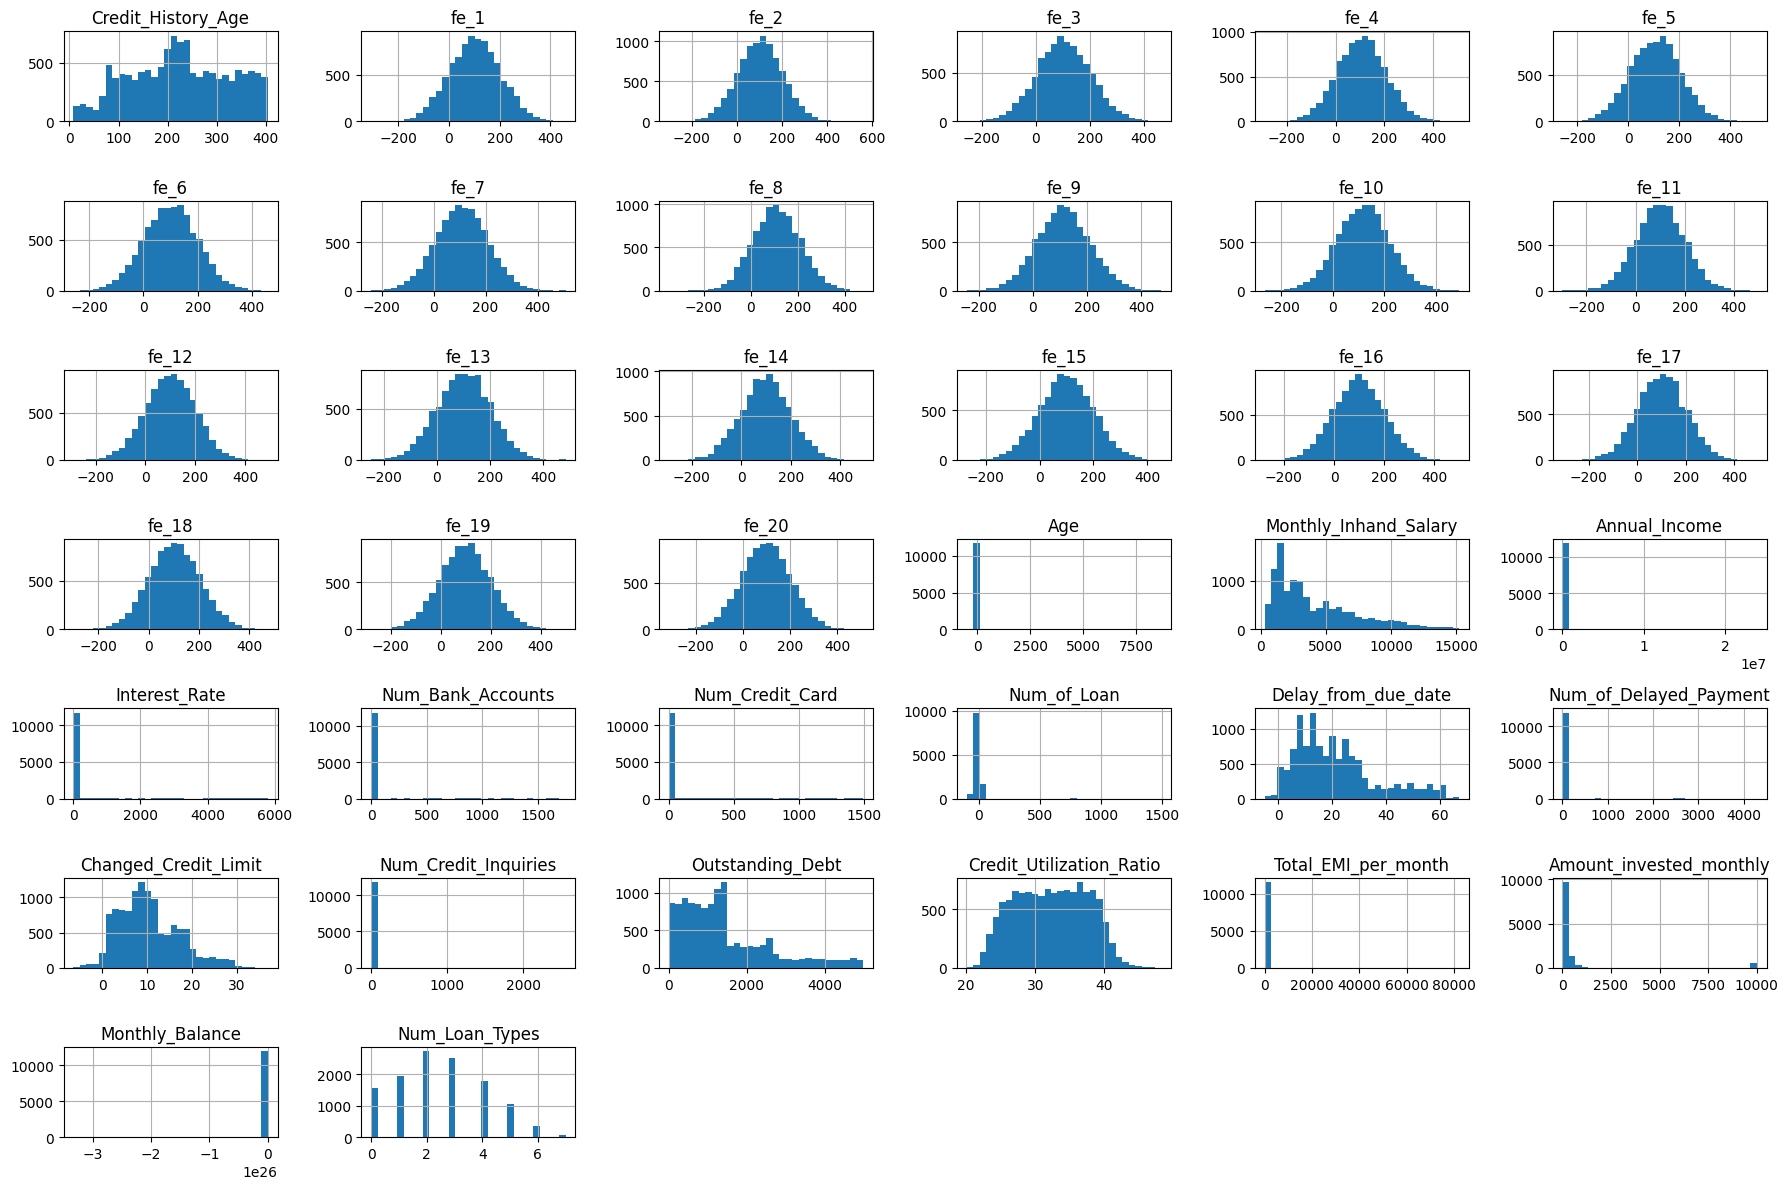

In [20]:
# Histograms
num_cols = pdf.select_dtypes(include=[np.number]).columns
pdf[num_cols].hist(figsize=(18, 12), bins=30)
plt.tight_layout()
plt.show()

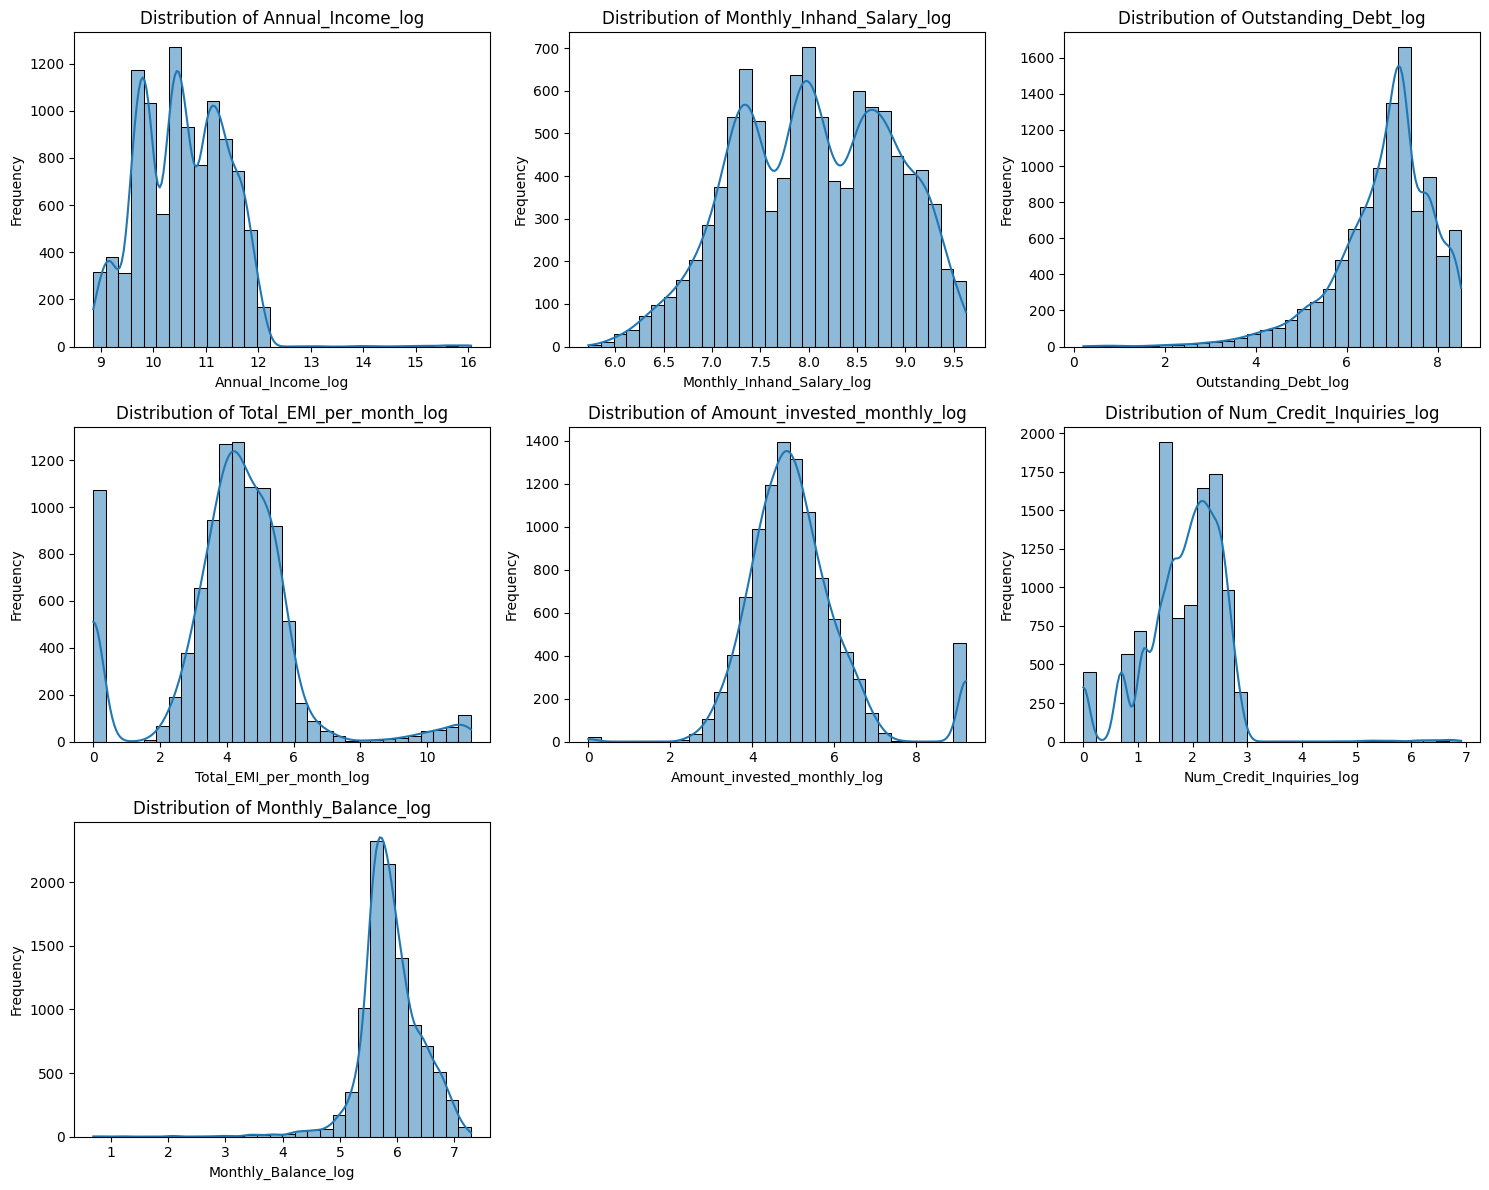

In [41]:
# Apply outlier filtering
def apply_threshold_filters(df):
    filters = (
        (df['Age'].between(18, 100)) &
        (df['Interest_Rate'].between(0, 100)) &
        (df['Num_Bank_Accounts'].between(0, 50)) &
        (df['Num_Credit_Card'].between(0, 50)) &
        (df['Num_of_Loan'] <= 20) &
        (df['Num_of_Delayed_Payment'] <= 100) &
        (df['Num_Credit_Inquiries'] <= 1000) &
        (df['Total_EMI_per_month'] < 100000) &
        (df['Amount_invested_monthly'] < 100000) &
        (df['Monthly_Balance'].between(-100000, 100000)) &
        (df['Annual_Income'] < 1e7) &
        (df['Outstanding_Debt'] < 1e7) &
        (df['Monthly_Inhand_Salary'] < 1e6)
    )
    return df[filters].copy()

# Apply log transformations
def apply_log_transformations(df):
    skewed_features = [
        'Annual_Income', 'Monthly_Inhand_Salary', 'Outstanding_Debt',
        'Total_EMI_per_month', 'Amount_invested_monthly', 'Num_Credit_Inquiries'
    ]
    df_log = df.copy()
    for col in skewed_features:
        df_log[f'{col}_log'] = np.log1p(df_log[col])

    # Monthly_Balance shifted log
    if 'Monthly_Balance' in df.columns:
        shift_val = df['Monthly_Balance'].min()
        df_log['Monthly_Balance_log'] = np.log1p(df['Monthly_Balance'] - shift_val + 1)

    return df_log

# Plot distributions of log-transformed features
def plot_log_feature_distributions(df_log):
    log_cols = [col for col in df_log.columns if col.endswith('_log')]
    n_cols = 3
    n_rows = -(-len(log_cols) // n_cols)  # ceiling division

    plt.figure(figsize=(n_cols * 5, n_rows * 4))
    for i, col in enumerate(log_cols, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.histplot(df_log[col].dropna(), kde=True, bins=30)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Run filtering and transformation
cleaned_pdf = apply_threshold_filters(pdf)
transformed_pdf = apply_log_transformations(cleaned_pdf)

(pdf.shape, cleaned_pdf.shape, transformed_pdf.shape)

plot_log_feature_distributions(transformed_pdf)

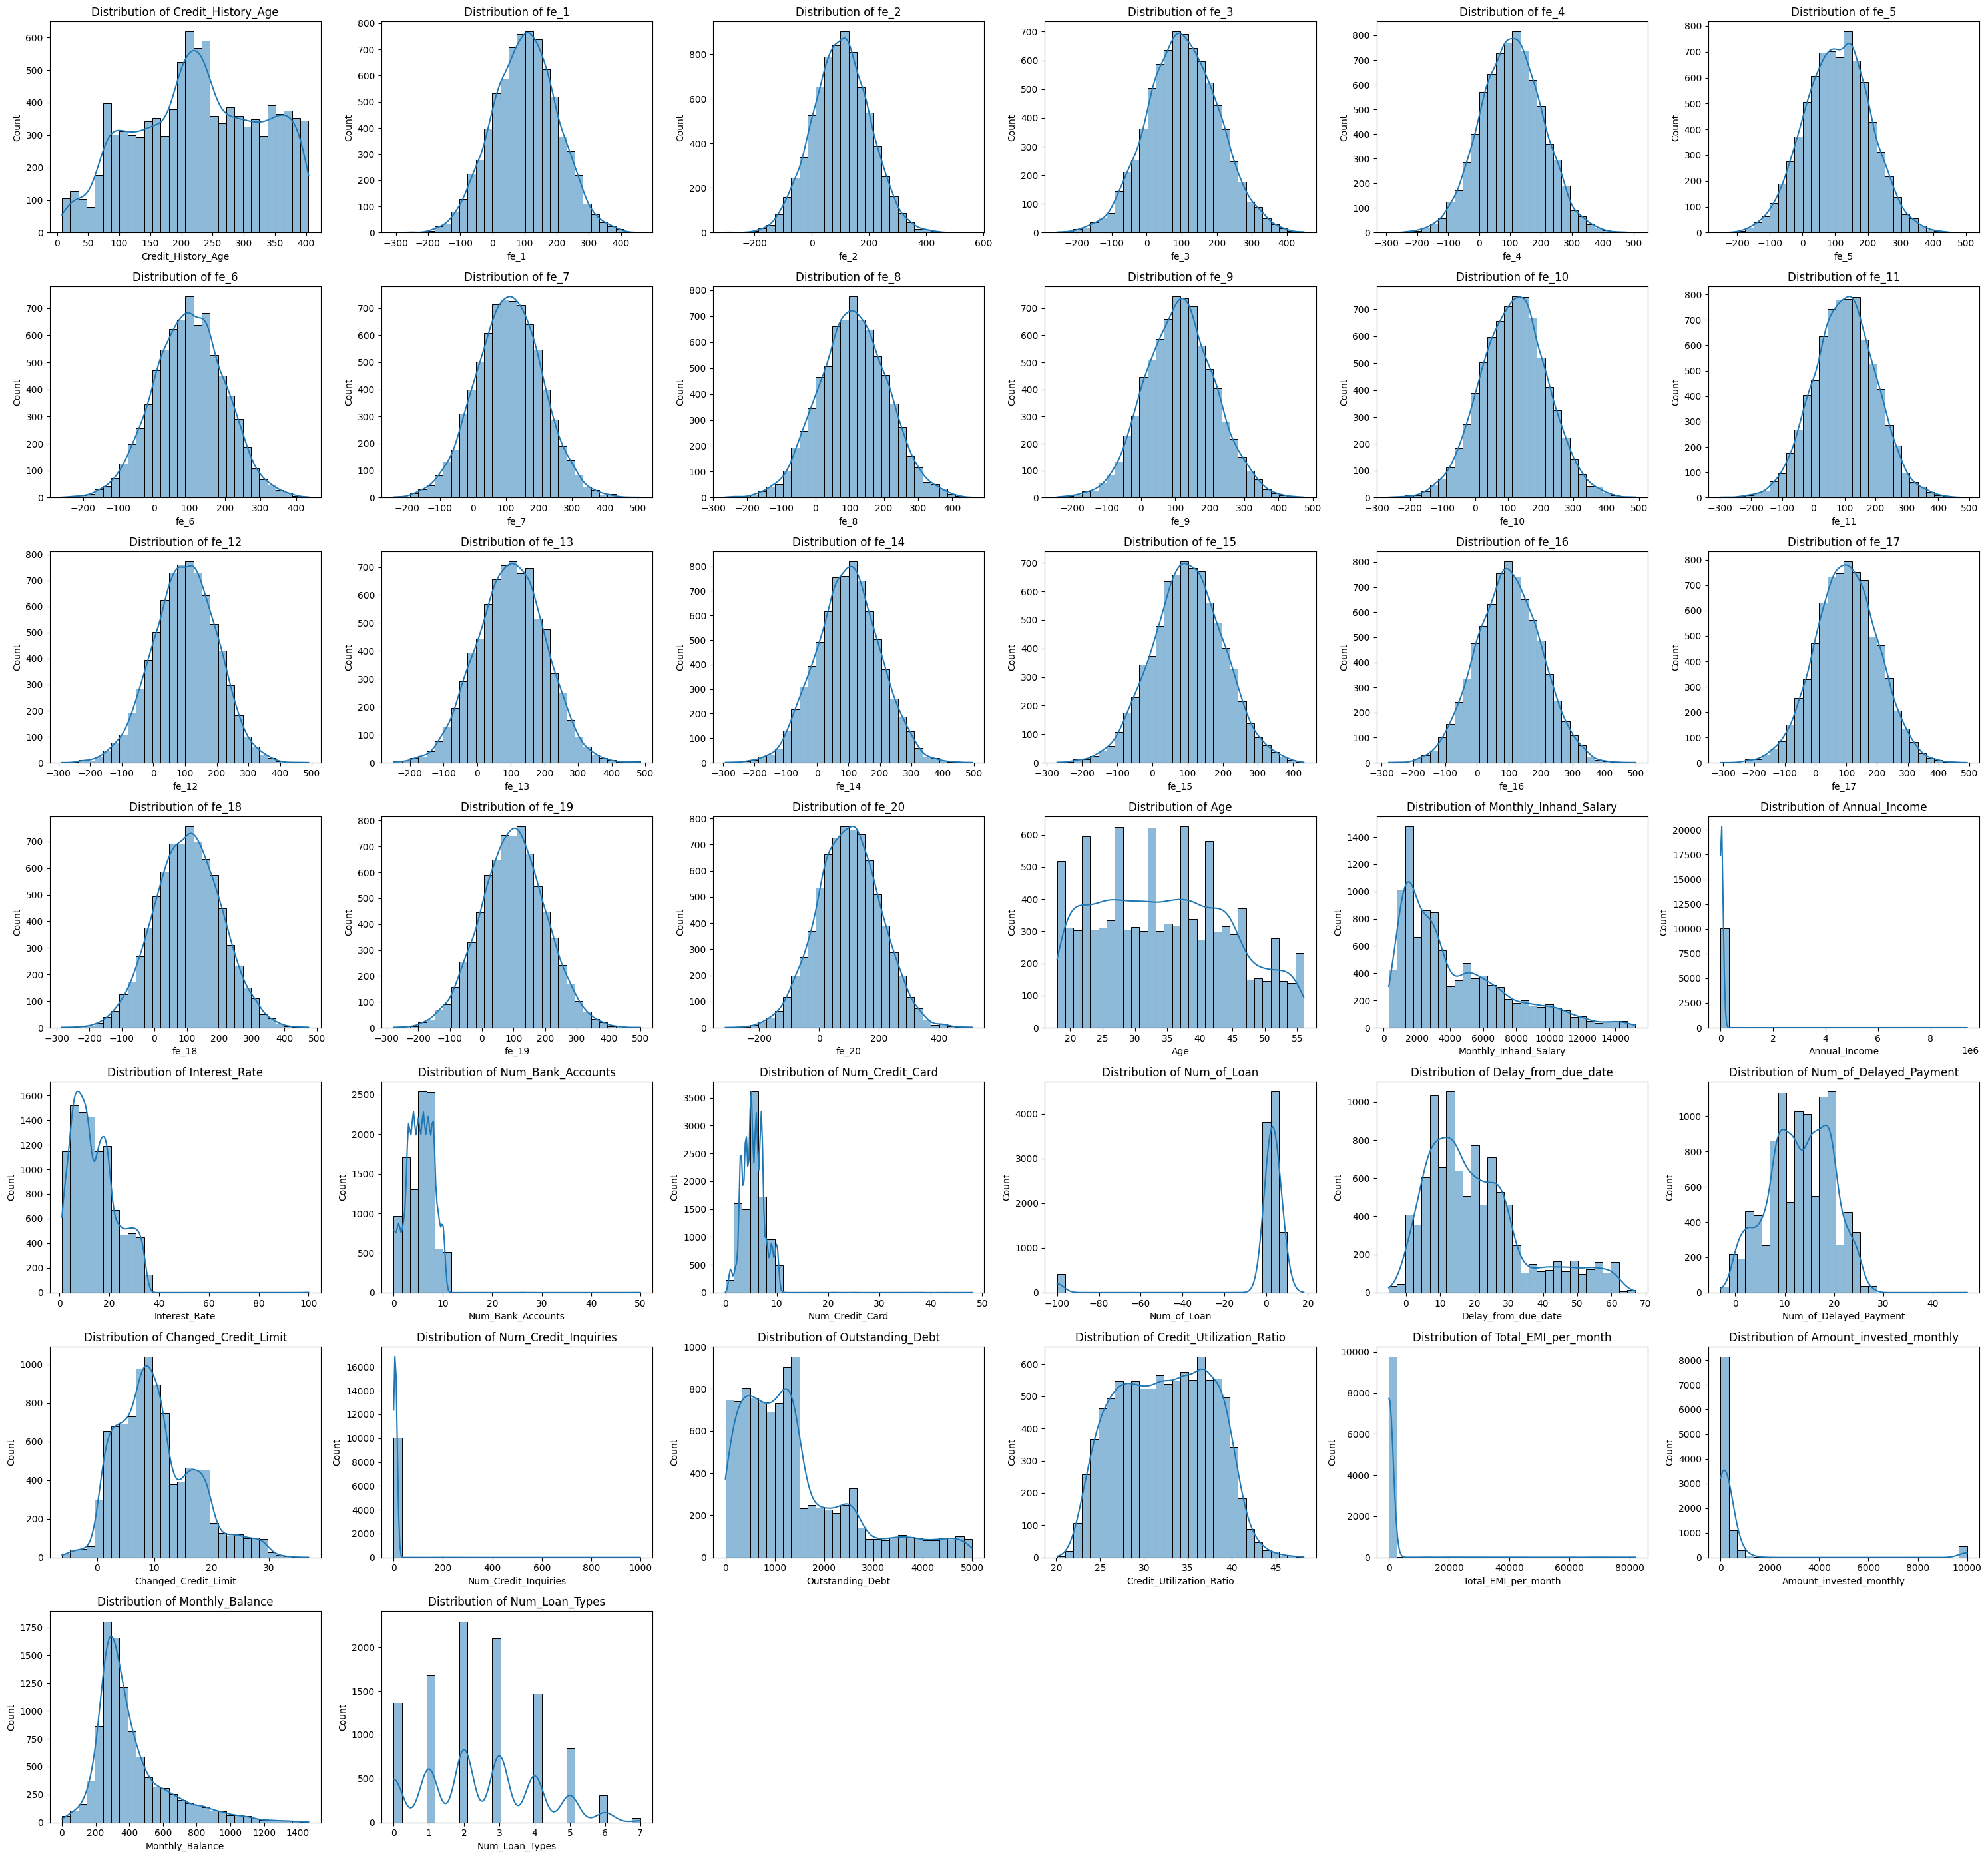

In [44]:
# Exclude log-transformed and categorical features
excluded = [col for col in transformed_pdf.columns if col.endswith('_log') or transformed_pdf[col].dtype == 'object']
remaining_numeric = transformed_pdf.drop(columns=excluded).select_dtypes(include=['int32', 'float32', 'float64']).columns

# Plot distributions
n_cols = 6
n_rows = -(-len(remaining_numeric) // n_cols)  # ceiling division

plt.figure(figsize=(n_cols * 5, n_rows * 4))
for i, col in enumerate(remaining_numeric, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(transformed_pdf[col].dropna(), kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

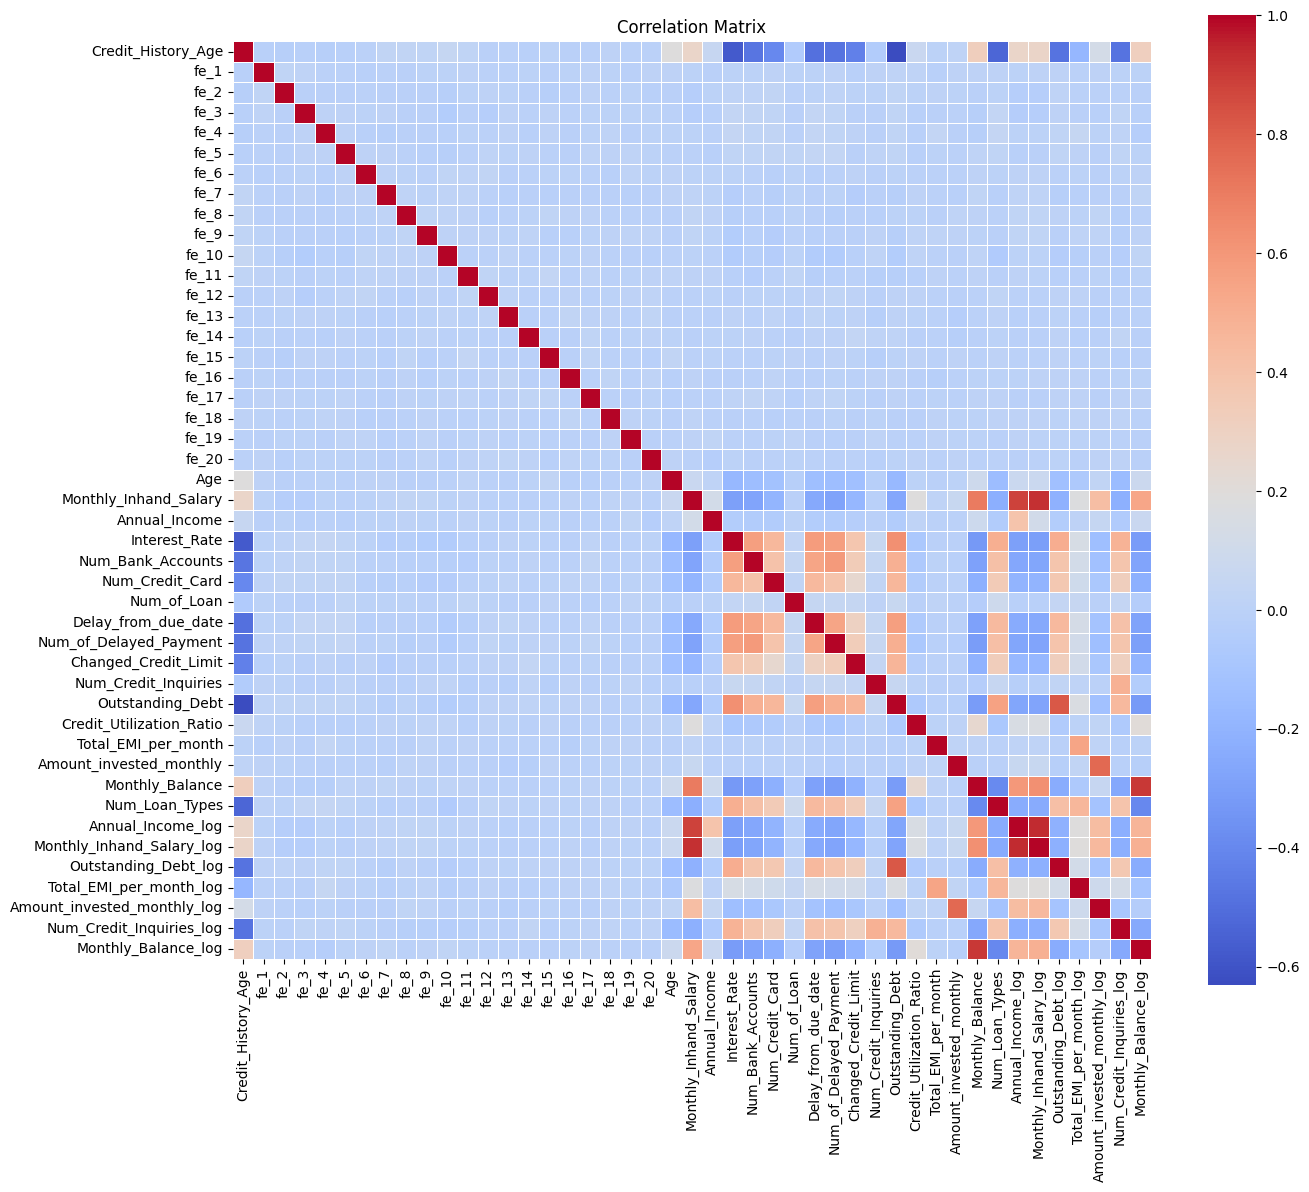

In [46]:
# Select only numeric columns for correlation check
numeric_cols = transformed_pdf.select_dtypes(include=[np.number])

# Compute correlation matrix
corr_matrix = numeric_cols.corr()

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, square=True, linewidths=0.5)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

In [64]:
# Define numeric columns (excluding identifiers and date columns)
numeric_cols = transformed_pdf.select_dtypes(include=['float', 'int']).columns.difference(['Customer_ID', 'snapshot_date', 'Annual_Income', 'Monthly_Inhand_Salary', 'Monthly_Balance', 'Amount_invested_monthly', 'Outstanding_Debt', 'Total_EMI_per_month', 'Monthly_Inhand_Salary_log'])

# Prepare VIF dataframe by replacing inf/-inf and dropping NaNs
vif_df = transformed_pdf[numeric_cols].replace([np.inf, -np.inf], np.nan).dropna()

X = add_constant(vif_df)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display results
print(vif_data.sort_values("VIF", ascending=False))

                        feature         VIF
0                         const  432.692491
8                 Interest_Rate    2.331471
14               Num_Loan_Types    2.204647
13     Num_Credit_Inquiries_log    2.064318
5            Credit_History_Age    2.038054
10            Num_Bank_Accounts    1.990843
3             Annual_Income_log    1.969746
7           Delay_from_due_date    1.941525
15       Num_of_Delayed_Payment    1.922811
9           Monthly_Balance_log    1.686508
17         Outstanding_Debt_log    1.547738
18      Total_EMI_per_month_log    1.493620
11              Num_Credit_Card    1.407547
12         Num_Credit_Inquiries    1.393632
2   Amount_invested_monthly_log    1.385322
4          Changed_Credit_Limit    1.309291
1                           Age    1.053780
6      Credit_Utilization_Ratio    1.051407
16                  Num_of_Loan    1.014098
20                        fe_10    1.010145
32                         fe_3    1.009419
22                        fe_12 

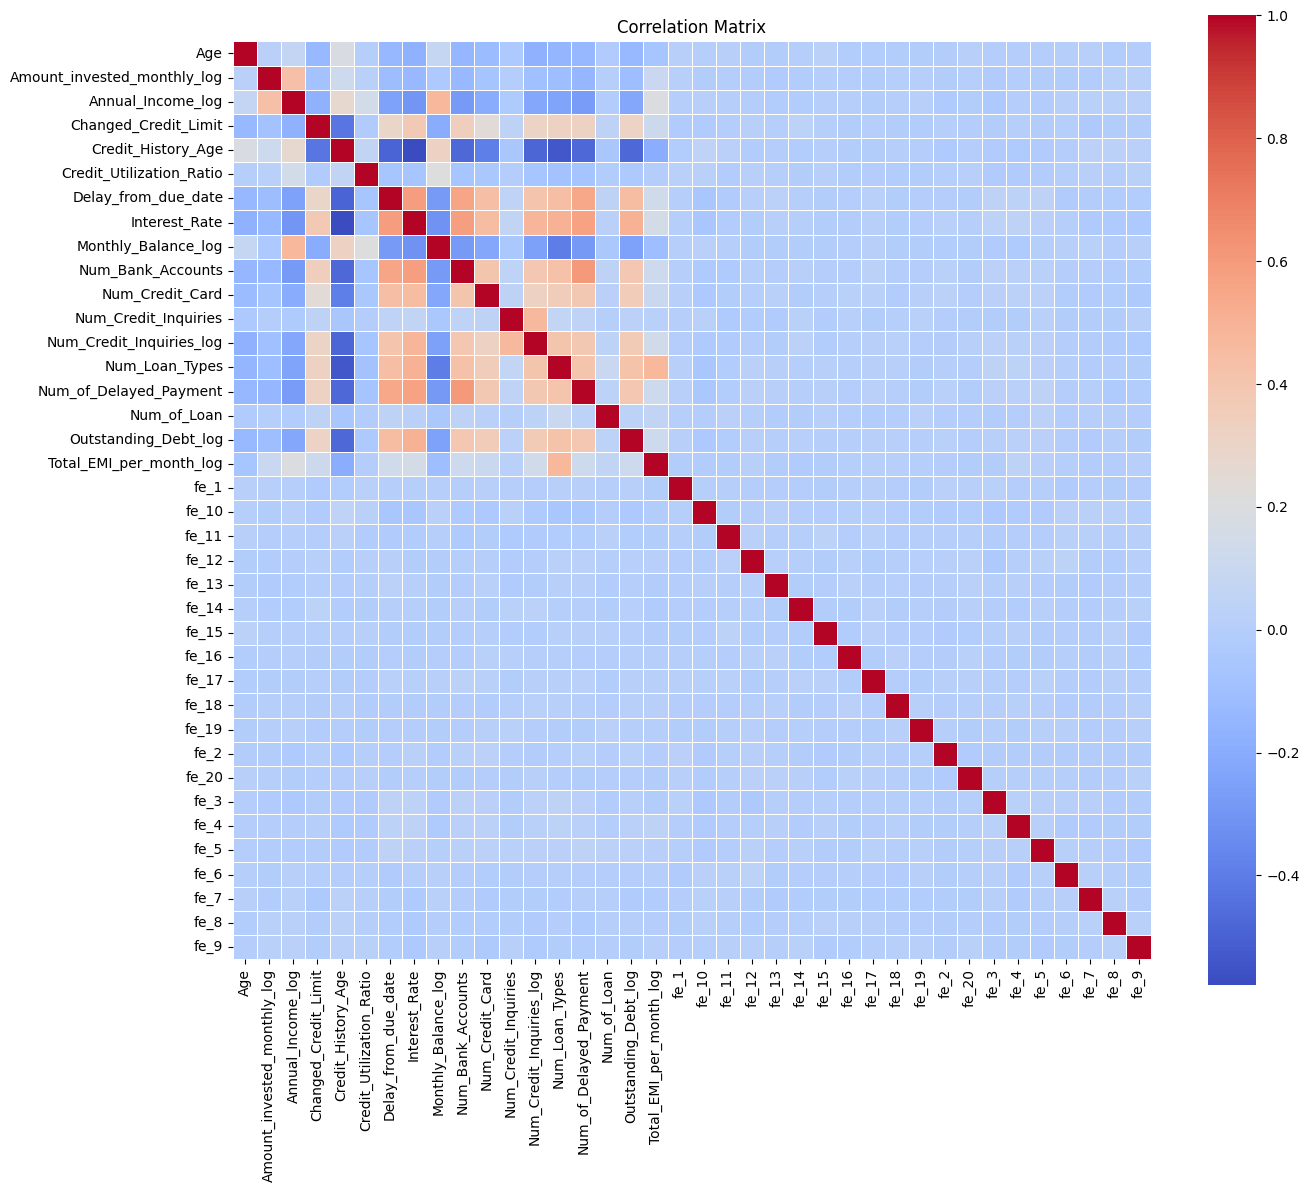

In [65]:
# Select only numeric columns for correlation check
numeric_cols = vif_df.select_dtypes(include=[np.number])

# Compute correlation matrix
corr_matrix = numeric_cols.corr()

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, square=True, linewidths=0.5)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

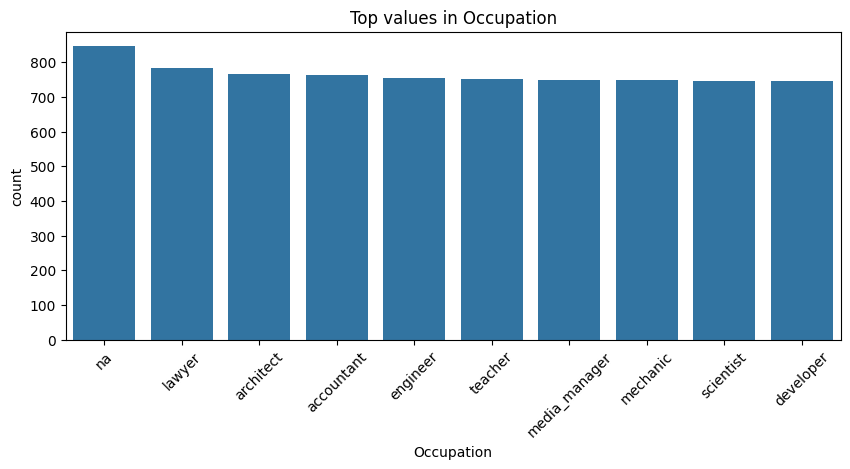

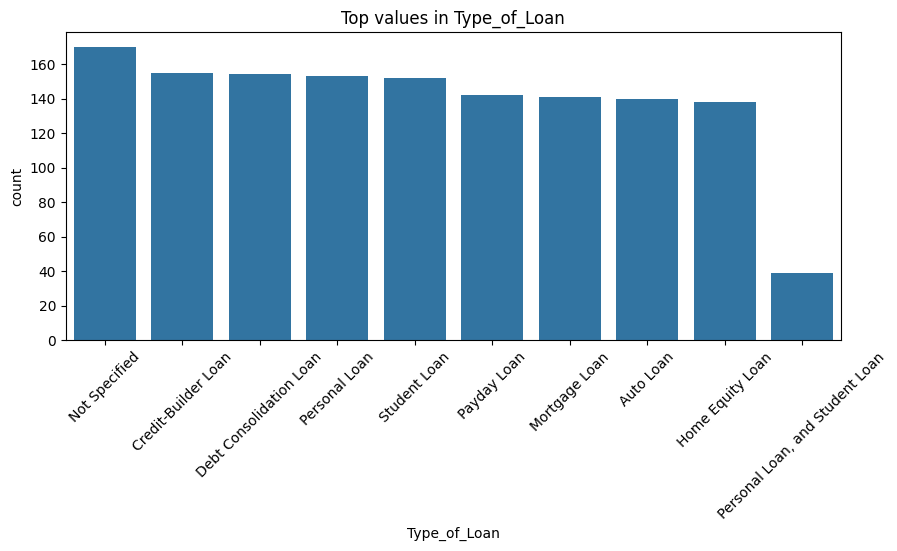

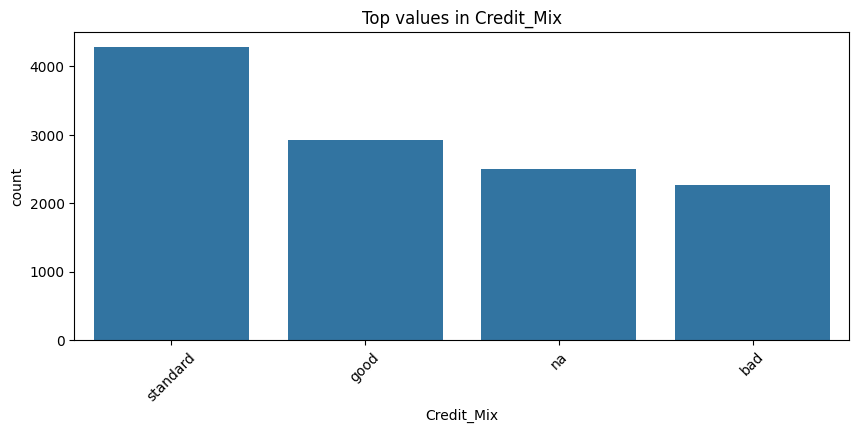

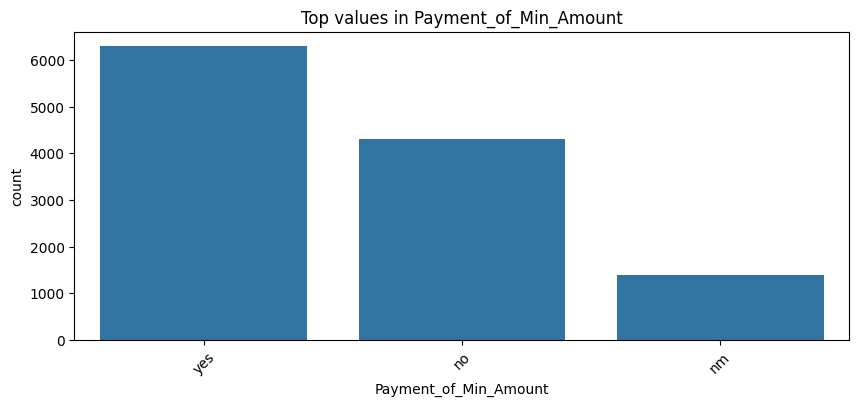

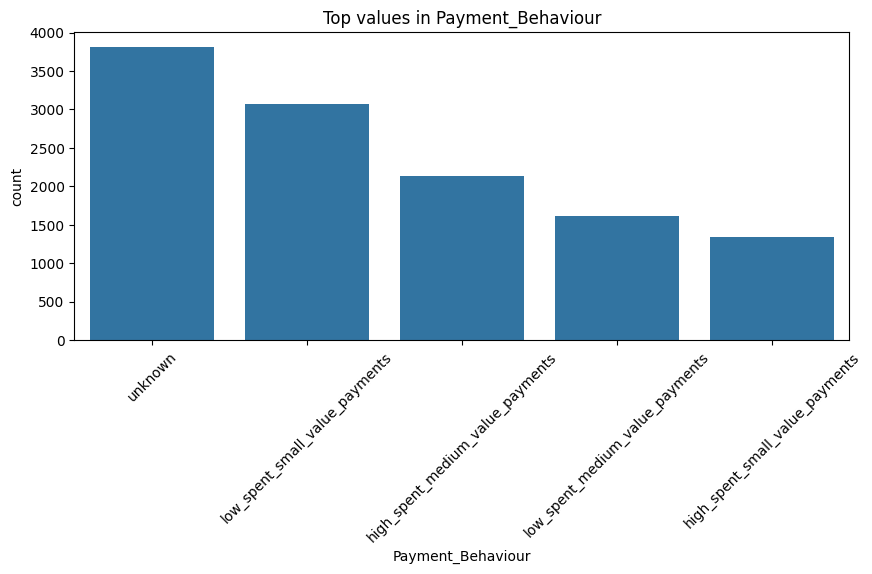

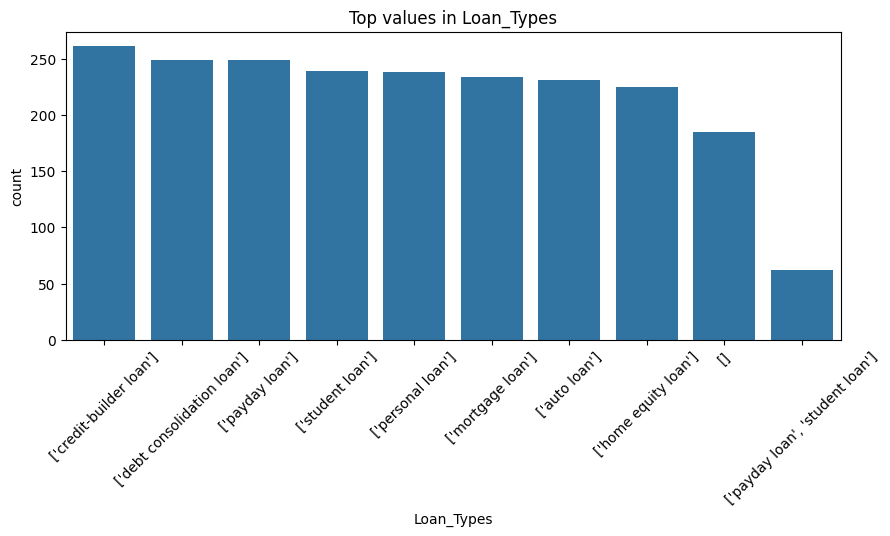

In [45]:
# Histograms
num_cols = pdf.select_dtypes(include=[np.number]).columns
pdf[num_cols].hist(figsize=(18, 12), bins=30)
plt.tight_layout()
plt.show()

# Bar plots for top 10 frequent values in categorical columns
cat_cols = pdf.select_dtypes(include='object').columns.drop(['Customer_ID', 'snapshot_date'], errors='ignore')
for col in cat_cols:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=pdf, x=col, order=pdf[col].value_counts().index[:10])
    plt.title(f"Top values in {col}")
    plt.xticks(rotation=45)
    plt.show()

## Build gold table for labels

In [6]:
# run gold backfill
for date_str in dates_str_lst:
    utils.data_processing_gold_features.process_gold_features_table(date_str, silver_features_directory, gold_features_directory, spark)


Loaded from: silver_feature_store_2023_01_01.parquet Row count: 530


Saved to: datamart/gold/feature_store/gold_feature_store_2023_01_01.parquet
Loaded from: silver_feature_store_2023_02_01.parquet Row count: 501


Saved to: datamart/gold/feature_store/gold_feature_store_2023_02_01.parquet
Loaded from: silver_feature_store_2023_03_01.parquet Row count: 506


Saved to: datamart/gold/feature_store/gold_feature_store_2023_03_01.parquet
Loaded from: silver_feature_store_2023_04_01.parquet Row count: 510
Saved to: datamart/gold/feature_store/gold_feature_store_2023_04_01.parquet
Loaded from: silver_feature_store_2023_05_01.parquet Row count: 521
Saved to: datamart/gold/feature_store/gold_feature_store_2023_05_01.parquet
Loaded from: silver_feature_store_2023_06_01.parquet Row count: 517
Saved to: datamart/gold/feature_store/gold_feature_store_2023_06_01.parquet
Loaded from: silver_feature_store_2023_07_01.parquet Row count: 471
Saved to: datamart/gold/feature_store/gold_feature_store_2023_07_01.parquet
Loaded from: silver_feature_store_2023_08_01.parquet Row count: 481
Saved to: datamart/gold/feature_store/gold_feature_store_2023_08_01.parquet
Loaded from: silver_feature_store_2023_09_01.parquet Row count: 454
Saved to: datamart/gold/feature_store/gold_feature_store_2023_09_01.parquet
Loaded from: silver_feature_store_2023_10_01.parquet Row cou

Saved to: datamart/gold/feature_store/gold_feature_store_2023_12_01.parquet
Loaded from: silver_feature_store_2024_01_01.parquet Row count: 485
Saved to: datamart/gold/feature_store/gold_feature_store_2024_01_01.parquet
Loaded from: silver_feature_store_2024_02_01.parquet Row count: 518
Saved to: datamart/gold/feature_store/gold_feature_store_2024_02_01.parquet
Loaded from: silver_feature_store_2024_03_01.parquet Row count: 511


Saved to: datamart/gold/feature_store/gold_feature_store_2024_03_01.parquet
Loaded from: silver_feature_store_2024_04_01.parquet Row count: 513
Saved to: datamart/gold/feature_store/gold_feature_store_2024_04_01.parquet
Loaded from: silver_feature_store_2024_05_01.parquet Row count: 491
Saved to: datamart/gold/feature_store/gold_feature_store_2024_05_01.parquet
Loaded from: silver_feature_store_2024_06_01.parquet Row count: 498
Saved to: datamart/gold/feature_store/gold_feature_store_2024_06_01.parquet
Loaded from: silver_feature_store_2024_07_01.parquet Row count: 505
Saved to: datamart/gold/feature_store/gold_feature_store_2024_07_01.parquet
Loaded from: silver_feature_store_2024_08_01.parquet Row count: 543


Saved to: datamart/gold/feature_store/gold_feature_store_2024_08_01.parquet
Loaded from: silver_feature_store_2024_09_01.parquet Row count: 493
Saved to: datamart/gold/feature_store/gold_feature_store_2024_09_01.parquet
Loaded from: silver_feature_store_2024_10_01.parquet Row count: 456
Saved to: datamart/gold/feature_store/gold_feature_store_2024_10_01.parquet
Loaded from: silver_feature_store_2024_11_01.parquet Row count: 488
Saved to: datamart/gold/feature_store/gold_feature_store_2024_11_01.parquet
Loaded from: silver_feature_store_2024_12_01.parquet Row count: 515
Saved to: datamart/gold/feature_store/gold_feature_store_2024_12_01.parquet


In [7]:
utils.data_processing_gold_features.process_gold_features_table(date_str, silver_features_directory, gold_features_directory, spark).dtypes


Loaded from: silver_feature_store_2024_12_01.parquet Row count: 515
Saved to: datamart/gold/feature_store/gold_feature_store_2024_12_01.parquet


[('Customer_ID', 'string'),
 ('Occupation', 'string'),
 ('Type_of_Loan', 'string'),
 ('Credit_Mix', 'string'),
 ('Credit_History_Age', 'float'),
 ('Payment_of_Min_Amount', 'string'),
 ('Payment_Behaviour', 'string'),
 ('fe_1', 'float'),
 ('fe_2', 'float'),
 ('fe_3', 'float'),
 ('fe_4', 'float'),
 ('fe_5', 'float'),
 ('fe_6', 'float'),
 ('fe_7', 'float'),
 ('fe_8', 'float'),
 ('fe_9', 'float'),
 ('fe_10', 'float'),
 ('fe_11', 'float'),
 ('fe_12', 'float'),
 ('fe_13', 'float'),
 ('fe_14', 'float'),
 ('fe_15', 'float'),
 ('fe_16', 'float'),
 ('fe_17', 'float'),
 ('fe_18', 'float'),
 ('fe_19', 'float'),
 ('fe_20', 'float'),
 ('Age', 'int'),
 ('Interest_Rate', 'int'),
 ('Num_Bank_Accounts', 'int'),
 ('Num_Credit_Card', 'int'),
 ('Num_of_Loan', 'int'),
 ('Delay_from_due_date', 'int'),
 ('Num_of_Delayed_Payment', 'int'),
 ('Changed_Credit_Limit', 'float'),
 ('Num_Credit_Inquiries', 'int'),
 ('Credit_Utilization_Ratio', 'float'),
 ('Loan_Types', 'array<string>'),
 ('Num_Loan_Types', 'int'),
 (

## Inspect Feature Store

In [8]:
folder_path = gold_features_directory
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",df.count())

df.show()

row_count: 10109
+-----------+-------------+--------------------+----------+------------------+---------------------+--------------------+-----+------+-----+------+-----+-----+-----+------+-----+-----+-----+------+------+-----+-----+-----+------+-----+------+-----+---+-------------+-----------------+---------------+-----------+-------------------+----------------------+--------------------+--------------------+------------------------+--------------------+--------------+------------------+--------------------+-----------------------+---------------------------+------------------------+-------------------+--------------------+--------------------+----------------------+----------------------------+-----------+
|Customer_ID|   Occupation|        Type_of_Loan|Credit_Mix|Credit_History_Age|Payment_of_Min_Amount|   Payment_Behaviour| fe_1|  fe_2| fe_3|  fe_4| fe_5| fe_6| fe_7|  fe_8| fe_9|fe_10|fe_11| fe_12| fe_13|fe_14|fe_15|fe_16| fe_17|fe_18| fe_19|fe_20|Age|Interest_Rate|Num_Bank_Accoun

In [9]:
df.printSchema()

root
 |-- Customer_ID: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Type_of_Loan: string (nullable = true)
 |-- Credit_Mix: string (nullable = true)
 |-- Credit_History_Age: float (nullable = true)
 |-- Payment_of_Min_Amount: string (nullable = true)
 |-- Payment_Behaviour: string (nullable = true)
 |-- fe_1: float (nullable = true)
 |-- fe_2: float (nullable = true)
 |-- fe_3: float (nullable = true)
 |-- fe_4: float (nullable = true)
 |-- fe_5: float (nullable = true)
 |-- fe_6: float (nullable = true)
 |-- fe_7: float (nullable = true)
 |-- fe_8: float (nullable = true)
 |-- fe_9: float (nullable = true)
 |-- fe_10: float (nullable = true)
 |-- fe_11: float (nullable = true)
 |-- fe_12: float (nullable = true)
 |-- fe_13: float (nullable = true)
 |-- fe_14: float (nullable = true)
 |-- fe_15: float (nullable = true)
 |-- fe_16: float (nullable = true)
 |-- fe_17: float (nullable = true)
 |-- fe_18: float (nullable = true)
 |-- fe_19: float (nullable = true